In [1]:
import gdown
import zipfile

## Caricamento ed estrazione del Dataset

In [2]:
!gdown 1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo

Downloading...
From (original): https://drive.google.com/uc?id=1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo
From (redirected): https://drive.google.com/uc?id=1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo&confirm=t&uuid=4d7f43ad-0955-4db6-a196-0da105627781
To: /content/Impressionism Dataset Smaller Version.zip
100% 1.05G/1.05G [00:23<00:00, 44.7MB/s]


In [3]:
zip = zipfile.ZipFile("Impressionism Dataset Smaller Version.zip")
zip.extractall()
zip.close()

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
import os
import random
import matplotlib.image as mpimg
import math
import numpy as np

## Gestione ed esplorazione del Dataset

In [5]:
training_path = "./Impressionism Dataset Smaller Version/Training"
test_path =  "./Impressionism Dataset Smaller Version/Test"
classes = os.listdir(training_path)
classes

['Monet', 'Cezanne', 'VanGogh', 'Matisse']

In [6]:
len(classes)

4

Analizzo il numero di immagini per autore nei dati di addestramento

In [7]:
occurrences_per_class = []
class_paths = []
for one_class in classes:

  path = os.path.join(training_path,one_class)
  class_paths.append(path)
  occurrences_per_class.append(len(os.listdir(path)))

occurrences_per_class

[399, 399, 399, 399]

Visualizzazione di alcune immagini, estrandone a caso una per autore

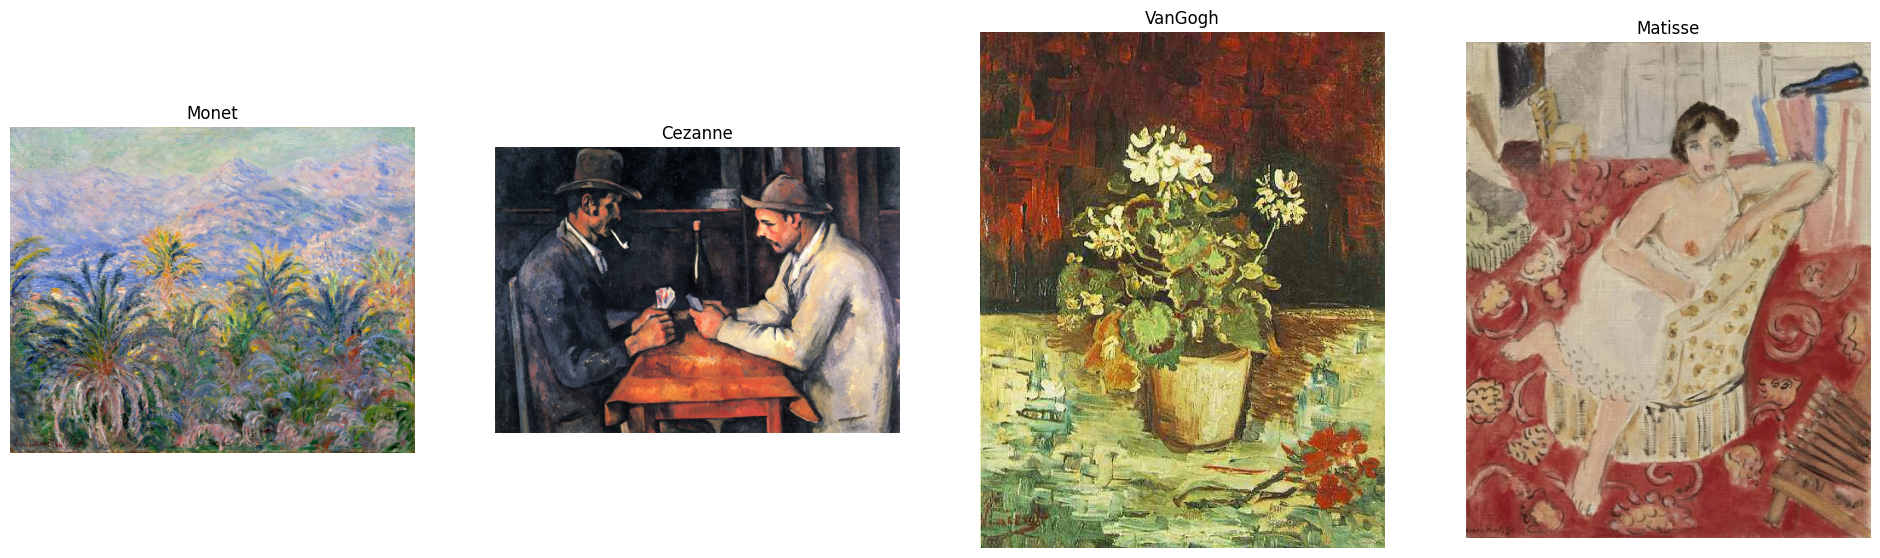

In [8]:
sample_images = []
for class_path in class_paths:
  images = os.listdir(class_path)
  sample_image = random.sample(images, 1)
  path__sample_image = os.path.join(class_path,sample_image[0])
  sample_images.append(path__sample_image)

shape_list = []
plt.figure(figsize=(24, 14))
for i,image in enumerate(sample_images):
        author = image.split("/")[-2]
        img = mpimg.imread(image)
        shape_list.append(img.shape)
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.title(author)
        plt.axis('off')
plt.show()

Problema: le immagini hanno dimensione diversa tra loro

In [9]:
shape_list

[(1536, 1904, 3), (1811, 2560, 3), (606, 475, 3), (600, 489, 3)]

array([[173, 186, 178, ..., 178, 190, 188],
       [172, 183, 175, ..., 182, 181, 203],
       [186, 194, 187, ..., 191, 182, 206],
       ...,
       [125, 138, 142, ..., 194, 201, 197],
       [153, 158, 161, ..., 176, 180, 187],
       [183, 175, 174, ..., 180, 182, 185]], dtype=uint8)
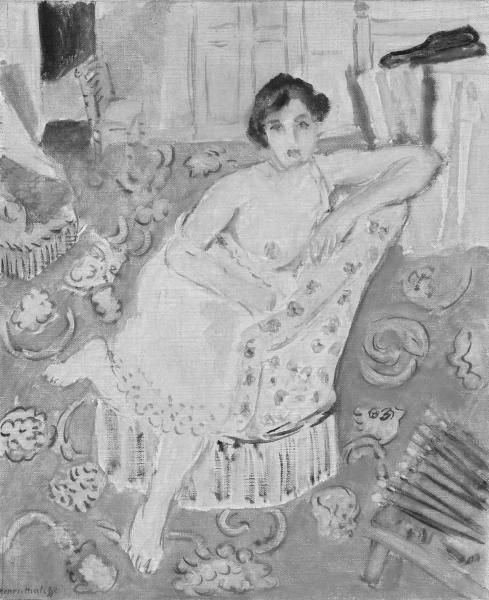

In [10]:
img[:,:,0]

In [11]:
img.shape

(600, 489, 3)

In [12]:
img[:,:,0].shape

(600, 489)

Analizzo il numero di immagini per autore nei dati di test

In [13]:
occurrences_per_class = []
for one_class in classes:

  class_path = os.path.join(test_path,one_class)
  occurrences_per_class.append(len(os.listdir(class_path)))

occurrences_per_class

[99, 99, 99, 99]

In [41]:
input_shape = (256,256,3)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1200 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 396 images belonging to 4 classes.


## Creazione della rete neurale

Nella creazione della rete bisogna tenere in considerazione la dimensione dell'output dell'ultimo layer di maxpooling e la dimensione del layer Dense

In [42]:
def conv_output_dimension(input_dimension,dimension_filter,number_filters,padding = 0, stride = 1):

  output_dim = int(((input_dimension + 2*padding - dimension_filter)/stride) + 1)

  output_shape = (output_dim,output_dim,number_filters)
  return output_shape


conv_output_dimension(256,3,32)



(254, 254, 32)

Analogamente

In [43]:
def maxpool_output_dimension(input_dimension,dimension_filter,padding = 0, stride = 2):

      output_dim = int(((input_dimension - dimension_filter) / stride) + 1)

      output_shape = (output_dim,output_dim)
      return output_shape

maxpool_output_dimension(254,2)

(127, 127)

In [44]:
x = np.random.rand(4, 256, 256, 3)
y = layers.Conv2D(32, 3, activation='relu')(x)
y = layers.MaxPooling2D((2,2))(y)
y_flat = layers.Flatten()(y)
print(y_flat.shape)

(4, 516128)


In [45]:
dense_number =  y.shape[1] * y.shape[1] * y.shape[-1]
dense_number

516128

In [62]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(classes), activation='softmax'))

In [63]:
initial_learning_rate = 0.01
decay_steps = 100

# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(
    train_generator,
    steps_per_epoch=1200//32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=396//32,
    callbacks= [early_stopping,model_checkpoint]
)

Epoch 1/30
37/37 [==============================] - 83s 2s/step - loss: 1.6819 - accuracy: 0.3005 - val_loss: 1.3364 - val_accuracy: 0.3359
Epoch 2/30
37/37 [==============================] - 85s 2s/step - loss: 1.3276 - accuracy: 0.3502 - val_loss: 1.3126 - val_accuracy: 0.3958
Epoch 3/30
37/37 [==============================] - 93s 3s/step - loss: 1.2401 - accuracy: 0.4247 - val_loss: 1.2197 - val_accuracy: 0.4714
Epoch 4/30
37/37 [==============================] - 52s 1s/step - loss: 1.1774 - accuracy: 0.4837 - val_loss: 1.2478 - val_accuracy: 0.4375
Epoch 5/30
37/37 [==============================] - 59s 2s/step - loss: 1.0812 - accuracy: 0.5385 - val_loss: 1.2757 - val_accuracy: 0.5078
Epoch 6/30
37/37 [==============================] - 94s 3s/step - loss: 1.0514 - accuracy: 0.5651 - val_loss: 1.1617 - val_accuracy: 0.5260
Epoch 7/30
37/37 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.5616

KeyboardInterrupt: 

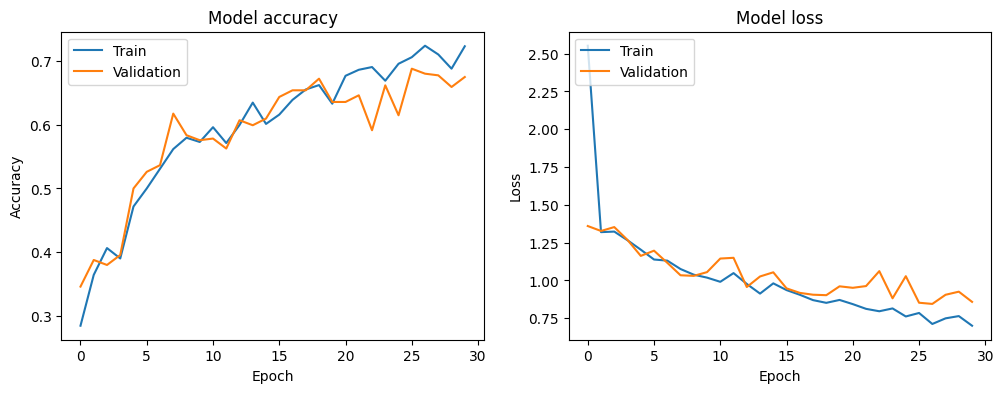

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("./Training_Curves.jpg")
plt.show()

In [25]:
model.save_weights('./weights.h5')

In [26]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")


13/13 [==============================] - 9s 691ms/step


In [27]:
pred = np.argmax(predicted_classes, axis = 1)
pred

array([0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 1, 0, 1, 1, 0, 0, 0, 3, 0, 0, 0, 1,
       0, 0, 3, 0, 0, 3, 3, 1, 3, 0, 2, 1, 3, 3, 0, 1, 2, 0, 1, 2, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 1, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 3,
       1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1,
       0, 0, 1, 0, 2, 1, 1, 0, 3, 1, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       2, 2, 0, 2, 0, 2, 2, 2, 3, 0, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2,
       2, 2, 1, 2, 2, 3, 0, 2, 3, 1, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3,
       3, 2, 0, 2, 2, 3, 0, 2, 2, 2, 2, 3, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 3, 3, 0, 2, 2, 3, 3, 3, 3,

In [28]:
true_labels = test_generator.labels
#true_labels = to_categorical(true_labels)
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,

In [29]:
accuracy = accuracy_score(true_labels, pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6616161616161617


In [30]:
conf_matrix = confusion_matrix(true_labels, pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[64 14  7 14]
 [20 62  3 14]
 [11  3 63 22]
 [16  3  7 73]]


In [31]:
class_report = classification_report(true_labels, pred)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        99
           1       0.76      0.63      0.69        99
           2       0.79      0.64      0.70        99
           3       0.59      0.74      0.66        99

    accuracy                           0.66       396
   macro avg       0.68      0.66      0.66       396
weighted avg       0.68      0.66      0.66       396



In [ ]:
from tensorflow.keras.applications import ResNet50


resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



model = Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(classes), activation='softmax'))